# Using Deep Learning Models for StabilityAnalysis of Non-Linear Differential Equations

Utku Elagoz

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive

import pickle
from scipy.linalg import logm
from scipy.optimize import fsolve
import numdifftools as nd
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import csv

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# Define the equations of motion for the nonlinear system
def equations_of_motion(x, t, params):

    x, y = x
    k, c = params

    # x1_dot = x2
    # x2_dot = -k * x1**3 + c * x2

    # x2_dot = -k * x1**3 + (c - x1**2) *x2

    x1_dot = -0.2 * x**3 + 0.4 * x - 0.1 * y
    x2_dot = 0.3 * x - 0.15 * y**2

    return [x1_dot, x2_dot]

In [ ]:
# the parameter ranges
k_range = np.linspace(0.1, 1.0, num=10)
c_range = np.linspace(0.5, 2.0, num=10)

# Generate parameters
parameter_combinations = [(k, c) for k in k_range for c in c_range]


In [ ]:
# Define the range for initial conditions
x1_range = np.linspace(-1.0, 1.0, num=20)
x2_range = np.linspace(-2.0, 2.0, num=20)

# Generate all possible combinations of initial conditions
initial_conditions = [(x1, x2) for x1 in x1_range for x2 in x2_range]


In [ ]:
# Define the simulation time span
t_start = 0.0
t_end = 10.0
num_points = 100

# Function to perform the simulation for a given set of parameters and initial conditions
def simulate_system(params, initial_conditions):
    t = np.linspace(t_start, t_end, num=num_points)
    sol = odeint(equations_of_motion, initial_conditions, t, args=(params,))
    return sol


In [ ]:
# Perform simulations for all parameter combinations and initial conditions
dataset = []
for params in parameter_combinations:
    for initial_condition in initial_conditions:
        sol = simulate_system(params, initial_condition)
        dataset.append((params, initial_condition, sol))


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/data/my_list1.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(dataset, file)

Mounted at /content/drive


In [ ]:
with open(file_path, 'rb') as file:
    dataset = pickle.load(file)

In [ ]:
# J = [[d(x1_dot)/dx1  d(x1_dot)/dx2],
#      [d(x2_dot)/dx1  d(x2_dot)/dx2]]

In [ ]:
num_points = sol.shape[0]
num_vars = sol.shape[1]
num_vars

2

In [ ]:
def compute_lyapunov_exponent(sol):
    num_points = sol.shape[0]
    num_vars = sol.shape[1]

    diff_matrix = np.zeros((num_points, num_vars, num_vars))

    for i in range(num_points):
        jac_matrix = np.zeros((num_vars, num_vars))
        for j in range(num_vars):
            for k in range(num_vars):
                # jac_matrix[j, k] = (sol[i, j] - sol[i, 0]) / (sol[i, k] - sol[i, 0])
                # jac_matrix[j, k] = ()
                x = sol[i, 0]
                y = sol[i, 1]
                if j == 0 and k == 0:
                    jac_matrix[j, k] = -0.6 * x**2 + 0.4
                elif j == 0 and k == 1:
                    jac_matrix[j, k] = -0.1
                elif j == 1 and k == 0:
                    jac_matrix[j, k] = 0.3
                elif j == 1 and k == 1:
                    jac_matrix[j, k] = -0.3 * y
                # np.array([[-0.6 * x**2 + 0.4, -0.1], [0.3, -0.3 * y]])

        diff_matrix[i] = jac_matrix
    diff_matrix_reshaped = diff_matrix.reshape(num_points, num_vars * num_vars)
    diff_matrix_transposed = np.transpose(diff_matrix_reshaped)

    lyapunov_spectrum = np.linalg.eigvals(logm(np.matmul(diff_matrix_transposed, diff_matrix_reshaped)) / (2 * t_end))
    max_lyapunov_exponent = np.max(lyapunov_spectrum.real)
    return max_lyapunov_exponent

# Function to determine stability based on the maximum Lyapunov exponent
def determine_stability(sol):
    max_lyapunov_exponent = compute_lyapunov_exponent(sol)

    # Define a threshold for stability
    stability_threshold = 0

    return 'Stable' if max_lyapunov_exponent < stability_threshold else 'Unstable'


In [ ]:
def compute_lyapunov_exponent(sol):
    num_points = sol.shape[0]
    num_vars = sol.shape[1]
    diff_matrix = np.zeros((num_points, num_vars, num_vars))

    for i in range(num_points):
        jac_matrix = np.zeros((num_vars, num_vars))
        for j in range(num_vars):
            for k in range(num_vars):
                x = sol[i, 0]
                y = sol[i, 1]
                if j == 0 and k == 0:
                    jac_matrix[j, k] = -0.6 * x**2 + 0.4
                elif j == 0 and k == 1:
                    jac_matrix[j, k] = -0.1
                elif j == 1 and k == 0:
                    jac_matrix[j, k] = 0.3
                elif j == 1 and k == 1:
                    jac_matrix[j, k] = -0.3 * y

        diff_matrix[i] = jac_matrix

    diff_matrix_reshaped = diff_matrix.reshape(num_points, num_vars * num_vars)
    diff_matrix_transposed = np.transpose(diff_matrix_reshaped)

    diff_matrix_reshaped[np.isinf(diff_matrix_reshaped)] = np.finfo(diff_matrix_reshaped.dtype).max  # Replace infinite values with maximum finite value

    cleaned_diff_matrix_reshaped = np.where(np.isfinite(diff_matrix_reshaped), diff_matrix_reshaped, 0.000001).astype(np.float64)
    cleaned_diff_matrix_transposed = np.where(np.isfinite(diff_matrix_transposed), diff_matrix_transposed, 0.000001).astype(np.float64)

    max_value = np.max(np.abs(cleaned_diff_matrix_reshaped))
    cleaned_diff_matrix_reshaped /= max_value
    cleaned_diff_matrix_transposed /= max_value

    # Clean the infinite values before matrix multiplication
    cleaned_diff_matrix_reshaped = np.nan_to_num(cleaned_diff_matrix_reshaped)
    cleaned_diff_matrix_transposed = np.nan_to_num(cleaned_diff_matrix_transposed)

    cleaned_covariance_matrix = np.matmul(cleaned_diff_matrix_reshaped, cleaned_diff_matrix_transposed)
    cleaned_log_covariance_matrix = logm(cleaned_covariance_matrix)
    cleaned_lyapunov_spectrum = np.linalg.eigvals(cleaned_log_covariance_matrix)

    max_lyapunov_exponent = np.max(cleaned_lyapunov_spectrum.real)

    return max_lyapunov_exponent




In [ ]:
def determine_stability(sol):
    max_lyapunov_exponent = compute_lyapunov_exponent(sol)

    # Define a threshold for stability
    stability_threshold = 0

    return 'Stable' if max_lyapunov_exponent < stability_threshold else 'Unstable'

# Clear infinite and NaN values from the dataset
cleaned_dataset = []

for params, initial_condition, sol in dataset:
    if np.isfinite(sol).all() and not np.isnan(sol).any():
        stability_label = determine_stability(sol)
        cleaned_dataset.append((params, initial_condition, sol, stability_label))



In [ ]:

# Save the labeled dataset to a CSV file
csv_filename = 'nonlinear_periodic_dataset.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Parameter1', 'Parameter2', 'Initial Condition1', 'Initial Condition2', 'Solution', 'Stability'])
    for params, initial_condition, sol, stability_label in cleaned_dataset:
        writer.writerow([params[0], params[1], initial_condition[0], initial_condition[1], sol, stability_label])


In [ ]:
# Load the labeled dataset
dataset = pd.read_csv('nonlinear_periodic_dataset.csv')

# Split the dataset into features and labels
X = dataset[['Parameter1', 'Parameter2', 'Initial Condition1', 'Initial Condition2']].values
y = dataset['Stability'].values

# Convert stability labels to numerical values (0 for stable, 1 for unstable)
y = np.where(y == 'Stable', 0, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data for compatibility with Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the deep learning model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

# Model summary
model.summary()



In [ ]:
pip install numdifftools

In [ ]:
def stability_analysis(F, x0):
    J = nd.Jacobian(F)
    x_eq = fsolve(F, x0)
    J_eq = J(x_eq)
    eigvals = np.linalg.eigvals(J_eq)
    if all(eigval < 0 for eigval in eigvals):
        return 'Stable'
    elif all(eigval > 0 for eigval in eigvals):
        return 'Unstable'
    else:
        return 'Saddle'

# Example
def F(x):
    x = np.asarray(x)
    return np.array([x[0]**3 - 3*x[0]*x[1]**2 - 1, 3*x[0]**2*x[1] - x[1]**3])

x0 = [1, 1]
print(stability_analysis(F, x0))


Unstable


In [ ]:
import numpy as np
from scipy.optimize import fsolve
import numdifftools as nd

def stability_analysis(F, x0):
    J = nd.Jacobian(F)
    x_eq = fsolve(F, x0)
    print(x_eq)
    J_eq = J(x_eq)
    print(J_eq)
    eigvals = np.linalg.eigvals(J_eq)
    if all(eigval < 0 for eigval in eigvals):
        return 'Stable'
    elif all(eigval > 0 for eigval in eigvals):
        return 'Unstable'
    else:
        return 'Saddle'

# Example
def F(x):
    x = np.asarray(x)
    #return np.array([x[1], -x[0] - x[1]**3])
    return np.array([-2 * x[0] - 3 * x[0] * x[1], 3 * x[1] - x[1]**2])

x0 = [1, 1]
print(stability_analysis(F, x0))


[0. 0.]
[[-2.  0.]
 [ 0.  3.]]
Saddle


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numdifftools as nd

def stability_analysis(F, x0):
    J = nd.Jacobian(F)
    x_eq = fsolve(F, x0)
    J_eq = J(x_eq)
    eigvals = np.linalg.eigvals(J_eq)
    if all(eigval < 0 for eigval in eigvals):
        stability = 'Stable'
    elif all(eigval > 0 for eigval in eigvals):
        stability = 'Unstable'
    else:
        stability = 'Saddle'
    return stability, eigvals

def generate_equation(a, b):
    def F(t, x):
        x = np.asarray(x)
        return np.array([x[1], -a*x[0] - b*x[1]**3])
    return F

def solve_equation(F, x0, t_span):
    sol = solve_ivp(F, t_span, x0)
    return sol.y

a_values = [1, 1.5, 2]
b_values = [1, 1.5, 2]
x0_values = [[1, 1], [1.5, 1.5], [2, 2]]
t_span = [0, 10]

results = []
for a in a_values:
    for b in b_values:
        F = generate_equation(a, b)
        for x0 in x0_values:
            sol = solve_equation(F, x0, t_span)
            stability, eigvals = stability_analysis(lambda x: F(0, x), x0)
            results.append({'a': a, 'b': b, 'x0': x0, 'sol': sol,
                            'stability': stability, 'eigvals': eigvals})

df = pd.DataFrame(results)
df.to_excel('results.xlsx', index=False)


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numdifftools as nd

def stability_analysis(F, x0):
    J = nd.Jacobian(F)
    x_eq = fsolve(F, x0)
    J_eq = J(x_eq)
    eigvals = np.linalg.eigvals(J_eq)
    if all(eigval < 0 for eigval in eigvals):
        stability = 'Stable'
    elif all(eigval > 0 for eigval in eigvals):
        stability = 'Unstable'
    else:
        stability = 'Saddle'
    return stability, eigvals

def generate_equation(a, b):
    def F(t, x):
        x = np.asarray(x)
        return np.array([x[1], -a*x[0] - b*x[1]**3])
    return F

# def solve_equation(F, x0, t_span):
#     sol = solve_ivp(F, t_span, x0)
#     #return sol.y
#     return sol.y[:, -1]

a_values = np.linspace(-10, 10, num=100)
b_values = np.linspace(-20, 20, num=100)

num_points = 2000

# Generate random points between [-2, -2] and [2, 2]
x_min, x_max = -200, 200
y_min, y_max = -200, 200

random_points = np.random.rand(num_points, 2) * (np.array([x_max, y_max]) - np.array([x_min, y_min])) + np.array([x_min, y_min])

x0_values = random_points
t_span = [0, 10]

results = []
for a in a_values:
    for b in b_values:
        F = generate_equation(a, b)
        for x0 in x0_values:
            # sol = solve_equation(F, x0, t_span)
            stability, eigvals = stability_analysis(lambda x: F(0, x), x0)
            results.append({'a': a, 'b': b, 'x0': x0,
                            'stability': stability, 'eigvals': eigvals})

df = pd.DataFrame(results)
df.to_excel('results.xlsx', index=False)

In [ ]:
df['stability'].unique()

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import root
import numdifftools as nd

def stability_analysis(F, x0):
    J = nd.Jacobian(F)
    x_eq = root(F, x0).x
    J_eq = J(x_eq)
    eigvals = np.linalg.eigvals(J_eq)
    if all(eigval < 0 for eigval in eigvals):
        stability = 'Stable'
    elif all(eigval > 0 for eigval in eigvals):
        stability = 'Unstable'
    else:
        stability = 'Saddle'
    return stability, eigvals

def generate_equation(a, b):
    def F(x):
        x = np.asarray(x)
        #return np.array([x[1], -a*x[0] - b*x[1]**3])
        return np.array([a * x[0] - b * x[0] * x[1], b * x[1] - x[1]**2])
    return F

a_values = np.linspace(-50, 50, num=101)
b_values = np.linspace(-100, 100, num=201)

x_min, x_max = -200, 200
y_min, y_max = -200, 200
num_points=10
random_points = np.random.rand(num_points, 2) * (np.array([x_max, y_max]) - np.array([x_min, y_min])) + np.array([x_min, y_min])

x0_values = random_points

results = []
for a in a_values:
    for b in b_values:
        F = generate_equation(a, b)
        for x0 in x0_values:
            stability, eigvals = stability_analysis(F, x0)
            results.append({'a': a, 'b': b, 'x0': x0,
                            'stability': stability, 'eigvals': eigvals})

df = pd.DataFrame(results)
df.to_excel('results.xlsx', index=False)


In [ ]:
df1 = df[['a', 'b', 'stability','eigvals']]

In [ ]:
print(df1.dtypes)
df1['eigvals'] = df1['eigvals'].astype(str)
df_without_duplicates = df1.drop_duplicates()


a            float64
b            float64
stability     object
eigvals       object
dtype: object


<ipython-input-47-cd19b8fa46dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['eigvals'] = df1['eigvals'].astype(str)


In [ ]:
df2= df_without_duplicates.drop(columns={'eigvals'})

In [ ]:
df_without_duplicates.to_excel('train_data.xlsx')

In [ ]:
# Custom function to convert 'eigvals' column to list of lists
def convert_eigvals(val):
    try:
        return [list(map(float, val.strip('[]').split(',')))]
    except (ValueError, AttributeError):
        return []

# Apply the custom function to 'eigvals' column
df1['eigvals'] = df1['eigvals'].apply(convert_eigvals)

# Calculate middle point of eigenvals excluding empty values
middle_points = [np.mean(eigval) if eigval else np.nan for eigval in df1['eigvals']]

# Filter out rows with NaN middle_points
mask = ~np.isnan(middle_points)
df_filtered = df1.loc[mask]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_filtered['a'], df_filtered['b'], np.array(middle_points)[mask],
                     c=df_filtered['stability'].map({'Stable': 'green', 'Unstable': 'red', 'Saddle': 'blue'}))

# Set labels for each axis
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Middle Point of eigenvals')

# Set colorbar for stability values
unique_stability = df_filtered['stability'].unique()
if len(unique_stability) > 1:
    legend = ax.legend(*scatter.legend_elements(), title='Stability')
    ax.add_artist(legend)
else:
    if len(unique_stability) > 0:
        ax.set_title(f'Stability: {unique_stability[0]}')
    else:
        ax.set_title('No stability values')

# Show the plot
plt.show()



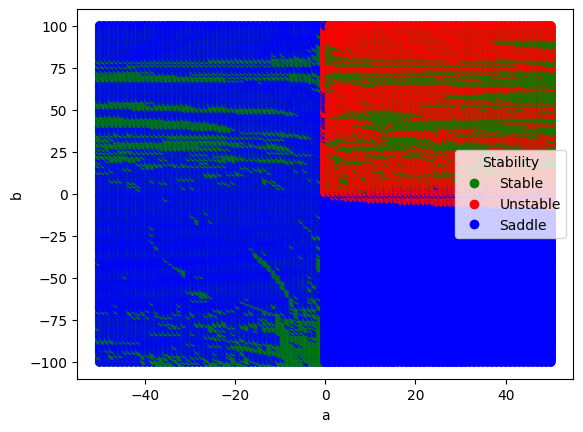

In [ ]:

# Create a DataFrame with sample data
data = {'a': [1, 2, 3, 4, 5],
        'b': [2, 4, 6, 8, 10],
        'stability': ['Stable', 'Unstable', 'Unstable', 'Stable', 'Saddle']}
df = pd.DataFrame(data)

# Define the color mapping for stability values
color_map = {'Stable': 'green', 'Unstable': 'red', 'Saddle': 'blue'}

# Scatter plot
plt.scatter(df2['a'], df2['b'], c=df2['stability'].map(color_map))

# Set labels for each axis
plt.xlabel('a')
plt.ylabel('b')

# Set colorbar for stability values
handles = [plt.plot([], [], color=color, marker='o', ls='')[0] for color in color_map.values()]
labels = list(color_map.keys())
plt.legend(handles, labels, title='Stability')

# Show the plot
plt.show()


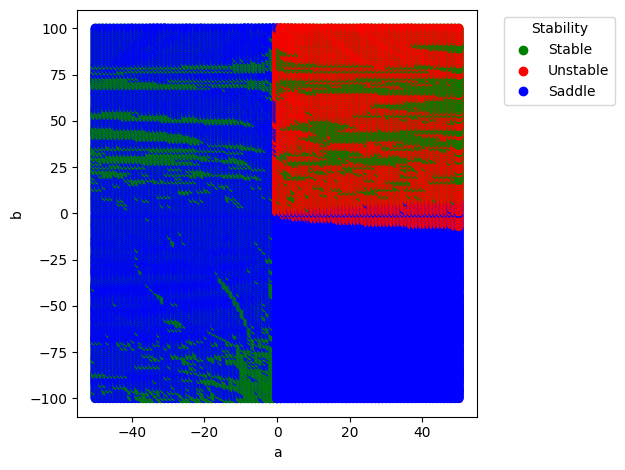

In [ ]:
# Define the color mapping for stability values
color_map = {'Stable': 'green', 'Unstable': 'red', 'Saddle': 'blue'}

# Scatter plot
plt.scatter(df2['a'], df2['b'], c=df2['stability'].map(color_map))

# Set labels for each axis
plt.xlabel('a')
plt.ylabel('b')

# Set colorbar for stability values
handles = [plt.plot([], [], color=color, marker='o', ls='')[0] for color in color_map.values()]
labels = list(color_map.keys())
legend = plt.legend(handles, labels, title='Stability', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
df_without_duplicates = pd.read_excel("train_data.xlsx")

In [ ]:
# Replace the lambda function with a custom function to handle the string conversion
def convert_string_to_array(string):
    # Remove square brackets and split the string by whitespace
    values = string.strip('[]').split()
    # Convert each value to a float
    float_values = [float(value) for value in values]
    # Return the array as a numpy array
    return np.array(float_values)

# Convert 'eigvals' column to numerical values
df_without_duplicates['eigvals'] = df_without_duplicates['eigvals'].apply(convert_string_to_array)

# Rest of your code

X = df_without_duplicates[['a', 'b', 'eigvals']].values
y = df_without_duplicates['stability'].values

label_map = {'Stable': 0, 'Unstable': 1, 'Saddle': 2}
y = np.vectorize(label_map.get)(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

num_classes = len(label_map)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)




In [ ]:

# Assuming df_without_duplicates is your DataFrame
X = df_without_duplicates[['a', 'b', 'eigvals']].values
y = df_without_duplicates['stability'].values

label_map = {'Stable': 0, 'Unstable': 1, 'Saddle': 2}
y = np.vectorize(label_map.get)(y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Defining the transformations for different columns
numeric_features = [0, 1]  # Indices of numeric columns (a and b)
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)])

# Fitting and transforming the training data
X_train = preprocessor.fit_transform(X_train)

# Transforming the testing data
X_test = preprocessor.transform(X_test)

print(X_train)

num_classes = len(label_map)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Rest of your code...
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)


In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test.argmax(axis=1), y_pred))

5513/5513 [==============================] - 8s 1ms/step
Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     61647
           1       0.96      0.95      0.96     23264
           2       0.99      0.97      0.98     91489

    accuracy                           0.98    176400
   macro avg       0.97      0.97      0.97    176400
weighted avg       0.98      0.98      0.98    176400



In [ ]:
from google.colab import drive
drive.mount('/content/drive')